In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# import data (just deal with level a for now)
data = pd.read_csv('OLIDv1.0/olid-training-v1.0.tsv', sep='\t', header=0, names=['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'])
data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [9]:
# split into training and dev
train, dev = sklearn.model_selection.train_test_split(data, test_size=0.1, shuffle=False) # 11916 train, 1324 dev
dev = dev.reset_index(drop=True)
dev.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,68082,@USER thanks for the following and together we...,NOT,NaN,NaN
1,31850,@USER @USER well done so many people will bene...,NOT,NaN,NaN
2,74460,@USER @USER @USER Saul does not suffer fools. ...,OFF,TIN,GRP
3,62367,@USER #metoo movement only applies to leftist ...,NOT,NaN,NaN
4,19240,@USER You are such a losing Democrat....No one...,OFF,TIN,IND


In [78]:
import re
import emoji
import itertools

def preprocess(tweet):
    # remove hashtags
    tweet = ' '.join(re.sub("(#[A-Za-z0-9]+)", " ", tweet).split())
    # remove punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    # lowercase
    tweet = tweet.lower()
    # replace emoji with text rep
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    # standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    return tweet

dev.tweet = [preprocess(tweet) for tweet in dev.tweet]
train.tweet = [preprocess(tweet) for tweet in train.tweet]

In [39]:
print(dev.tweet[17])

@user @user @user united_kingdom @user @user exactly why the is getting ffs angry_face tries to defend its borders &amp the stamps down hard angry_face angry_face angry_face url


NOT    884
OFF    440
Name: subtask_a, dtype: int64


<AxesSubplot:xlabel='subtask_a', ylabel='count'>

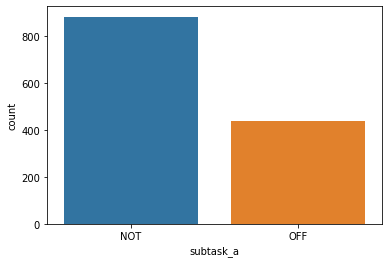

In [59]:
# investigating class imbalance
import seaborn as sns
print(dev.subtask_a.value_counts())
sns.countplot(x='subtask_a', data=dev)

In [51]:
from nltk import word_tokenize

def get_fastText(data):
   fastTweet = [word_tokenize('__label__' + label + ' ' + tweet) for label, tweet in zip(data.subtask_a, data.tweet)]
   return fastTweet

import csv
  
def make_file(data, output_file, keep=1):    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        for row in get_fastText(data):
            csv_writer.writerow(row)

make_file(train, 'tweets.train')
make_file(dev, 'tweets.dev')

In [97]:
## FastText classifier ##

import fasttext

# reloading already trained model
model = fasttext.load_model('models/fasttext.ftz')

# ###################
# hyper_params = {"lr": 0.01,
#                 "epoch": 100,
#                 "wordNgrams": 2,
#                 "dim": 20}     

# model = fasttext.train_supervised(input='tweets.train', **hyper_params)
# # reduces size of model and saves
# model.quantize(input='tweets.train', qnorm=True, retrain=True, cutoff=100000)
# model.save_model(os.path.join('models/','fasttext' + ".ftz"))
# ###################

model_acc_training_set = model.test('tweets.train')
model_acc_validation_set = model.test('tweets.dev')
# DISPLAY ACCURACY OF TRAINED MODEL
text_line = str(hyper_params) + " \naccuracy: " + str(model_acc_training_set[1])  + "\nvalidation: " + str(model_acc_validation_set[1]) + '\n' 
print(text_line)


{'lr': 0.01, 'epoch': 100, 'wordNgrams': 2, 'dim': 20} 
accuracy: 0.9950486740516952
validation: 0.7424471299093656



In [150]:
# Now to test, have it predict on the test set level a, after it's been preprocessed,
# then create a confusion matrix with the given labels, yeah, there you go 
test = pd.read_csv('OLIDv1.0/testset-levela.tsv', sep='\t', header=0, names=['id', 'tweet'])
test.tweet = [preprocess(tweet) for tweet in test.tweet]

def get_preds(model, test_data):
    # involves some parsing to get just the letters 'OFF' or 'NOT
    return[model.predict(tweet)[0][0][-3:] for tweet in test_data.tweet]

y_hat = get_preds(model, test)
test_y = pd.read_csv('OLIDv1.0/labels-levela.csv', sep=',', header=None, names=['id', 'label'])
y_true = test_y.label

from sklearn.metrics import classification_report
print(classification_report(y_true, y_hat))


              precision    recall  f1-score   support

         NOT       0.81      0.87      0.84       620
         OFF       0.59      0.49      0.53       240

    accuracy                           0.76       860
   macro avg       0.70      0.68      0.69       860
weighted avg       0.75      0.76      0.76       860



In [184]:
## char-level CNN ##

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train.tweet)

# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

# Convert string to index
train_sequences = tk.texts_to_sequences(train.tweet)
dev_texts = tk.texts_to_sequences(dev.tweet)
test_texts = tk.texts_to_sequences(test.tweet)

# Padding
train_data = pad_sequences(train_sequences, maxlen=160, padding='post') # longest seq is 155 in train
dev_data = pad_sequences(dev_texts, maxlen=160, padding='post')
test_data = pad_sequences(test_texts, maxlen=160, padding='post')

# Convert to numpy array
train_data_np = np.array(train_data, dtype='float32')
dev_data_np = np.array(dev_data, dtype='float32')
test_data_np = np.array(test_data, dtype='float32')
print(tk.word_index)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, ',': 37, ';': 38, '.': 39, '!': 40, '?': 41, ':': 42, "'": 43, '"': 44, '/': 45, '\\': 46, '|': 47, '_': 48, '@': 49, '#': 50, '$': 51, '%': 52, '^': 53, '&': 54, '*': 55, '~': 56, '`': 57, '+': 58, '-': 59, '=': 60, '<': 61, '>': 62, '(': 63, ')': 64, '[': 65, ']': 66, '{': 67, '}': 68, 'UNK': 69}


In [231]:
from keras.utils import to_categorical

# offensive is 1, not is 0
classes_to_binary = {'OFF': 1, 'NOT': 0}#k:v for v, k in enumerate(train.subtask_a.unique())}

train_labels = np.array([classes_to_binary[label] for label in train.subtask_a])
dev_labels = np.array([classes_to_binary[label] for label in dev.subtask_a])
test_labels = np.array([classes_to_binary[label] for label in test_y.label]) 

n_labs = 3
# train_labels = np.array([to_categorical(i, num_classes=n_labs) for i in train.binary_labels])
# dev_labels = np.array([to_categorical(i, num_classes=n_labs) for i in dev.binary_labels])
# test_labels = np.array([to_categorical(i, num_classes=n_labs) for i in test_y.binary_labels])

print('Input sequence dimensions (n.tweets, seq.length):', train_data_np.shape)
print('Label dimensions (n.tweets, class):', train_labels.shape)
print(train_labels[:5])


Input sequence dimensions (n.tweets, seq.length): (11916, 160)
Label dimensions (n.tweets, class): (11916,)
[1 1 0 1 0]


In [232]:
vocab_size = len(tk.word_index)+1
embed_size = 128

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

lstm_model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True, trainable=True),
    keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # 2 directions, 50 units each, concatenated (can change this)
    keras.layers.Dropout(0.5),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=None),
  ])

lstm_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# early stopping criteria based on area under the curve: will stop if no improvement after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', verbose=1, patience=3, mode='max', restore_best_weights=True)

# the number of training epochs we'll use, and the batch size (how many texts are input at once)
EPOCHS = 100
BATCH_SIZE = 32

print('**Defining a neural network**')
lstm_model.summary()

**Defining a neural network**
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 128)         8960      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, None, 100)         71600     
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 80,661
Trainable params: 80,661
Non-trainable params: 0
_________________________________________________________________


In [234]:
# lstm_model.predict(train_data_np[:10])
# results = lstm_model.evaluate(train_data_np, train_labels, batch_size=BATCH_SIZE, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))
lstm_model.fit(train_data_np, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_data_np, dev_labels))

Train on 11916 samples, validate on 1324 samples
Epoch 1/100
11916/11916 [==============================] - 117s 10ms/sample - loss: 0.7015 - accuracy: 0.6574 - val_loss: 0.6932 - val_accuracy: 0.6677
Epoch 2/100
11916/11916 [==============================] - 112s 9ms/sample - loss: 0.6932 - accuracy: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.6677
Epoch 3/100
11916/11916 [==============================] - 112s 9ms/sample - loss: 0.6932 - accuracy: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.6677
Epoch 4/100
11916/11916 [==============================] - 112s 9ms/sample - loss: 0.6932 - accuracy: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.6677
Epoch 5/100
11916/11916 [==============================] - 112s 9ms/sample - loss: 0.6932 - accuracy: 0.6677 - val_loss: 0.6932 - val_accuracy: 0.6677
Epoch 6/100
11916/11916 [==============================] - 112s 9ms/sample - loss: 0.6931 - accuracy: 0.6677 - val_loss: 0.6931 - val_accuracy: 0.6677
Epoch 7/100
11916/11916 [===================

In [152]:
# Models to test: 
#   naive ft vectors: whether or not it contains a set of predefined offensive words (can manually create) --> that's a naive feature vector
#   fastText (fasttext is word2vec but also incorporate character n-grams)
#   CNN or LSTM

In [ ]:
# We examine three categories of adversarial examples:
# false alarms (adding "not" before offensive words) - this is interesting bc just adding 'not' doesn't make a sentence semantically benign

# misspelling keywords (idiot, stupid, moron)

# self-censorship of profanity
# edit distance! This is a good way to do this. have an edit distance generator and then you can plot quantitatively by how large the edit distance is. 
NSFW = ['fuck']
##  having a set of replacement spellings in a dictionary ('idiot': ['iidiot', 'i.diot'])
sneaky = {'dumbass': 'dumb@$$', 
'pussy': 'pu$$y', 
'ass': 'a$$', 
'fuck': 'f*ck', 
'fucking': 'f*cking', 
'hell':'h*ll', 
'cunt': 'c*nt',
'hoe': 'h*e',
'sex': 's*x'
}